# Transform

In [ ]:
#| default_exp transform
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Overview
...

### Requirements

In [ ]:
#| export
from networkx import DiGraph
from graph_rewrite.core import NodeName, EdgeName, _create_graph, _plot_graph, _graphs_equal, GraphRewriteException
from graph_rewrite.lhs import lhs_to_graph
from graph_rewrite.match_class import Match
from graph_rewrite.matcher import find_matches, FilterFunc
from graph_rewrite.render_rhs import RenderFunc
from graph_rewrite.rules import Rule
from typing import *

### Transformation Utilities

In [ ]:
#| export
exceptions = {
    "no_such_node": lambda node: f"Node {node} does not exist in the input graph.",
    "no_such_edge": lambda edge: f"Edge {edge} does not exist in the input graph.",
    "no_such_attr_in_node": lambda attr, node: f"Attribute {attr} does not exist in input graph's node {node}.",
    "no_such_attr_in_edge": lambda attr, edge: f"Attribute {attr} does not exist in input graph's edge {edge}.",
    "edge_exists": lambda edge: f"Edge {edge} already exists in the input graph."
}

In [ ]:
#| export
def _generate_new_node_name(graph: DiGraph, base_name: NodeName) -> NodeName:
    new_name = base_name
    i = 0
    while new_name in graph.nodes():
        i += 1
        new_name = f"{base_name}_{i}"
    return new_name

In [ ]:
#| export
def _clone_node(graph: DiGraph, node_to_clone: NodeName) -> NodeName:
    if node_to_clone not in graph.nodes:
        raise GraphRewriteException(exceptions["no_such_node"](node_to_clone))

    # Create a new node name
    clone_name = _generate_new_node_name(graph, node_to_clone)

    # Add this new node to graph
    cloned_node_attrs = graph.nodes(data=True)[node_to_clone]
    graph.add_node(clone_name, **cloned_node_attrs)

    # Clone edges (connect the clone to all original edge endpoints + copy attrs)
    for n, _ in graph.in_edges(node_to_clone):
        if (n, clone_name) not in graph.edges():
            cloned_edge_attrs = graph.edges[n, node_to_clone]
            graph.add_edge(n, clone_name, **cloned_edge_attrs)
    
    for _, n in graph.out_edges(node_to_clone):
        if (clone_name, n) not in graph.edges():
            cloned_edge_attrs = graph.edges[node_to_clone, n]
            graph.add_edge(clone_name, n, **cloned_edge_attrs)
 
    return clone_name

In [ ]:
#| export
def _remove_node(graph: DiGraph, node_to_remove: NodeName):
    if node_to_remove not in graph.nodes():
        raise GraphRewriteException(exceptions["no_such_node"](node_to_remove))
    graph.remove_node(node_to_remove)

In [ ]:
#| export
def _remove_edge(graph: DiGraph, edge_to_remove: EdgeName):
    if edge_to_remove not in graph.edges():
        raise GraphRewriteException(exceptions["no_such_edge"](edge_to_remove))
    graph.remove_edge(*edge_to_remove)

In [ ]:
#| export
def _remove_node_attrs(graph: DiGraph, node: NodeName, attrs_to_remove: set):
    if node not in graph.nodes():
        raise GraphRewriteException(exceptions["no_such_node"](node))
    for attr in attrs_to_remove:
        if attr not in graph.nodes[node]:
            raise GraphRewriteException(exceptions["no_such_attr_in_node"](attr, node))
        del graph.nodes[node][attr]

In [ ]:
#| export
def _remove_edge_attrs(graph: DiGraph, edge: EdgeName, attrs_to_remove: set):
    if edge not in graph.edges():
        raise GraphRewriteException(exceptions["no_such_edge"](edge))
    for attr in attrs_to_remove:
        if attr not in graph.edges[edge]:
            raise GraphRewriteException(exceptions["no_such_attr_in_edge"](attr, edge))
        del graph.edges[edge][attr]

In [ ]:
#| export
def _merge_nodes(graph: DiGraph, nodes_to_merge: set[NodeName]) -> NodeName:
    # TODO: not implemented yet
    pass

In [ ]:
#| export
def _add_node(graph: DiGraph, node_to_add: NodeName) -> NodeName:
    # Create a new node name
    new_name = _generate_new_node_name(graph, node_to_add)
    graph.add_node(new_name)
    return new_name

In [ ]:
#| export
def _add_edge(graph: DiGraph, edge_to_add: EdgeName):
    src, target = edge_to_add
    if src not in graph.nodes():
        raise GraphRewriteException(exceptions["no_such_node"](src))
    elif target not in graph.nodes():
        raise GraphRewriteException(exceptions["no_such_node"](target))
    elif edge_to_add in graph.edges():
        raise GraphRewriteException(exceptions["edge_exists"](edge_to_add))
    else:
        graph.add_edge(src, target)

In [ ]:
#| export
def _add_node_attrs(graph: DiGraph, node: NodeName, attrs_to_add: dict):
    if node not in graph.nodes():
        raise GraphRewriteException(exceptions["no_such_node"](node))
    for attr, val in attrs_to_add.items():
        graph.nodes[node][attr] = val

In [ ]:
#| export
def _add_edge_attrs(graph: DiGraph, edge: EdgeName, attrs_to_add: dict):
    if edge not in graph.edges():
        raise GraphRewriteException(exceptions["no_such_edge"](edge))
    for attr, val in attrs_to_add.items():
        graph.edges[edge][attr] = val

### Not implemented yet!

### Rewrite Match

In [ ]:
#| export
def rewrite_match_restrictive(input_graph: DiGraph, rule: Rule, lhs_input_map: dict[NodeName, NodeName]) -> dict[NodeName, NodeName]:
    # Initialize an empty mapping from P nodes to input_graph nodes.
    p_input_map = {}

    """Clone nodes:
        Find all LHS nodes that should be cloned (and what are their clones in P).
        For each clone of an LHS node (apart from the first one), add it to the input graph 
        (clone with edges and attributes) and add the pair (clone_name, lhs_node_name) to the p->input mapping.
    """
    cloned_lhs_nodes = rule.nodes_to_clone().keys()
    for cloned_lhs_node, p_clones in rule.nodes_to_clone().items():
        for index, p_clone in enumerate(p_clones):
            # The first clone is basically the original rhs node, no need to add anything to input graph
            if index == 0:
                print(f"Clone {lhs_input_map[cloned_lhs_node]}")
                p_input_map[p_clone] = lhs_input_map[cloned_lhs_node]
            # All other clones require actual cloning (mapped to the new cloned node in input graph)
            else:
                new_clone_id = _clone_node(input_graph, lhs_input_map[cloned_lhs_node])
                print(f"Clone {lhs_input_map[cloned_lhs_node]} as {new_clone_id}")
                p_input_map[p_clone] = new_clone_id

    """Remove nodes, complete p->input mapping with preserved nodes which are not clones:
        Find all LHS nodes that should be removed. 
        For each LHS node, if should be removed - remove it from input.
                            otherwise, if it is not a clone, add to the mapping.
    """
    for lhs_node in rule.lhs.nodes():
        if lhs_node in rule.nodes_to_remove():
            print(f"Remove node {lhs_input_map[lhs_node]}")
            _remove_node(input_graph, lhs_input_map[lhs_node])
        # Cloned nodes were already cloned and handled
        elif lhs_node not in cloned_lhs_nodes:
            p_node = list(rule._rev_p_lhs[lhs_node])[0]
            p_input_map[p_node] = lhs_input_map[lhs_node]

    # Remove edges.
    for lhs_src, lhs_target in rule.edges_to_remove():
        print(f"Remove edge ({p_input_map[lhs_src]}, {p_input_map[lhs_target]})")
        _remove_edge(input_graph, (p_input_map[lhs_src], p_input_map[lhs_target]))

    # Remove node attrs.
    for p_node, attrs_to_remove in rule.node_attrs_to_remove().items():
        print(f"Remove attrs {attrs_to_remove} from node {p_input_map[p_node]}")
        _remove_node_attrs(input_graph, p_input_map[p_node], attrs_to_remove)

    # Remove edge attrs.
    for (p_src, p_target), attrs_to_remove in rule.edge_attrs_to_remove().items():
        print(f"Remove attrs {attrs_to_remove} from edge {(p_input_map[p_src], p_input_map[p_target])}")
        _remove_edge_attrs(input_graph, (p_input_map[p_src], p_input_map[p_target]), attrs_to_remove)

    return p_input_map

In [ ]:
#| export
def rewrite_match_expansive(input_graph: DiGraph, rule: Rule, p_input_map: dict[NodeName, NodeName]):
    # Initialize an empty mapping from RHS nodes to input_graph nodes.
    rhs_input_map = {}

    """Merge nodes:
        Find all RHS nodes that are a merge of P nodes (and what P nodes they merge).
        For each RHS node that is a merge, merge all of the relavant P node, add the resulting RHS node to the input.
        Also removes from input the P nodes that were merged into a new node.
        Save the new RHS merged node to the RHS->input mapping.
    """
    merge_rhs_nodes = rule.nodes_to_merge().keys()
    for merge_rhs_node, p_merged in rule.nodes_to_merge().items():
        input_nodes_to_merge = [p_input_map[p_node] for p_node in p_merged]
        new_merged_id = _merge_nodes(input_graph, input_nodes_to_merge)
        print(f"Merge {input_nodes_to_merge} as {new_merged_id}")
        rhs_input_map[merge_rhs_node] = new_merged_id

    """Add nodes, complete RHS->input mapping with added (and preserved) nodes:
        Find all RHS nodes that should be added to the input (not including nodes that are a merge of P noeds).
        For each RHS node, if should be added - add it to input and to the RHS->input mapping.
                            otherwise, if is not a merge - add to the mapping.
    """
    for rhs_node in rule.rhs.nodes():
        if rhs_node in rule.nodes_to_add():
            added_id = _add_node(input_graph, rhs_node)
            print(f"Add node {rhs_node} as {added_id}")
            rhs_input_map[rhs_node] = added_id
        elif rhs_node not in merge_rhs_nodes:
            p_node = list(rule._rev_p_rhs[rhs_node])[0]
            rhs_input_map[rhs_node] = p_input_map[p_node]

    # Add edges.
    for rhs_src, rhs_target in rule.edges_to_add():
        print(f"Add edge ({rhs_input_map[rhs_src]}, {rhs_input_map[rhs_target]})")
        _add_edge(input_graph, (rhs_input_map[rhs_src], rhs_input_map[rhs_target]))

    # Add node attrs.
    for rhs_node, attrs_to_add in rule.node_attrs_to_add().items():
        print(f"Added attrs {attrs_to_add} to node {rhs_input_map[rhs_node]}")
        _add_node_attrs(input_graph, rhs_input_map[rhs_node], attrs_to_add)

    # Add edge attrs.
    for (rhs_src, rhs_target), attrs_to_add in rule.edge_attrs_to_add().items():
        print(f"Added attrs {attrs_to_add} to edge {(rhs_input_map[rhs_src], rhs_input_map[rhs_target])}")
        _add_edge_attrs(input_graph, (rhs_input_map[rhs_src], rhs_input_map[rhs_target]), attrs_to_add)

In [ ]:
#| export
def rewrite_match(input_graph: DiGraph, match: Match, rule: Rule):
  lhs_input_map = match.mapping
  p_input_map = rewrite_match_restrictive(input_graph, rule, lhs_input_map)
  rewrite_match_expansive(input_graph, rule, p_input_map)

### Rewrite Graph
Our library's main function.

In [ ]:
# def rewrite(input_graph: DiGraph, lhs: str, p: str = None, rhs: str = None, condition: FilterFunc = None, render_rhs = None, merge_policy = None):
#     pass

In [ ]:
OKGREEN = '\033[92m'
WARNING = '\033[93m'

def log(msg, color=OKGREEN):
    ENDC = '\033[0m'
    print(f"{color}{msg}{ENDC}")

In [ ]:
def rewrite(input_graph: DiGraph, lhs: str, p: DiGraph = None, rhs: DiGraph = None,
                   condition: FilterFunc = lambda match: True) -> List[Match]:
        # TODO: Allow repairing to original input graph if an exception was raised
        lhs_graph, condition = lhs_to_graph(lhs, condition)
        matches = find_matches(input_graph, lhs_graph, condition=condition)
        log(f"\nNodes: {input_graph.nodes(data=True)}\nEdges: {input_graph.edges(data=True)}")
        log(f"Found {len(matches)} matches.")
        # TODO: change p to str, parse it
        # TODO: change rhs to str, parse it, render it with render_rhs
        rule = Rule(lhs_graph, p, rhs) # TODO: add merge_policy
        for index, match in enumerate(matches):
            log(f"Transform match {index}: {match.mapping}")
            rewrite_match(input_graph, match, rule)
            log(f"\nNodes: {input_graph.nodes(data=True)}\nEdges: {input_graph.edges(data=True)}")
              
        return matches

### Tests

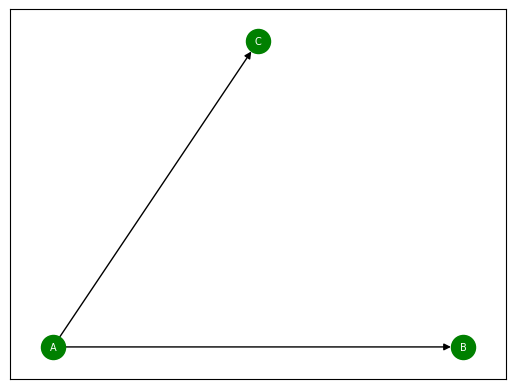

In [ ]:
input_graph = _create_graph(
    ['A',('B', {'attr': 5}),'C'], 
    [
        ('A', 'B', {'attr2': 7}),
        ('A', 'C'),
    ]
)
_plot_graph(input_graph)


Nodes: [('A', {}), ('B', {'attr': 5}), ('C', {})]
Edges: [('A', 'B', {'attr2': 7}), ('A', 'C', {})]
Found 1 matches.
Transform match 0: {'1': 'A', '2': 'B'}
Remove attrs {'attr2'} from edge ('A', 'B')
Add edge (B, A)
Added attrs {'attr': 7} to node B

Nodes: [('A', {}), ('B', {'attr': 7}), ('C', {})]
Edges: [('A', 'B', {}), ('A', 'C', {}), ('B', 'A', {})]


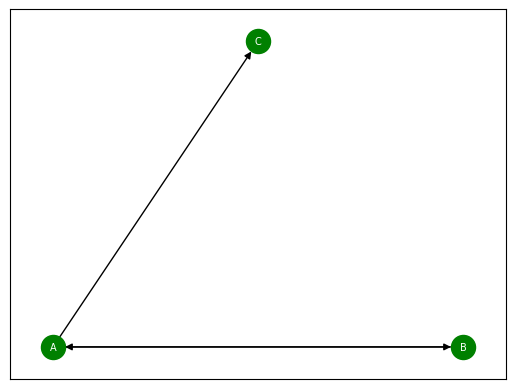

In [ ]:
lhs = '1-[attr2]->2'
p = _create_graph(
    ['1', '2'], 
    [('1', '2')]
)
rhs = _create_graph(
    ['1', ('2', {'attr': 7})], 
    [('1', '2'), ('2', '1')]
)
matches = rewrite(input_graph, lhs, p, rhs)
_plot_graph(input_graph)